### Koding Inisiasi

In [1]:
# import

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import math
import random

import sys

In [2]:
# Membuat fungsi untuk menilai dampak policy terhadap lingkungan
# Semakin nilai fungsi ini mendekati 0 maka semuanya akan semakin bagus

def g(P, X):
    i = 0
    sigma_sx = 0
    sigma_s = 0
    while i < len(P):
        sigma_sx = sigma_sx + P[i][0]*X[i]
        sigma_s = sigma_s + P[i][0]
        i += 1
    return 1-(sigma_sx/sigma_s)

In [3]:
# Membuat fungsi payoff untuk action yang mungkin di timestep berikutnya
# untuk pemain-i. AAAAA AKU SAYANG ZETA

# player adalah pemain ke berapa yang sedang dicari payoff functionnya (ingat indeks python)
# action adalah aksi (berapa persen (dalam desimal) investasi) pemain-i untuk timestep berikutnya
# P adalah matriks pemain. Nanti diambil aksi pemain lain selain pemain i
# X adalah matriks payoff

# Fungsi ini nanti digunakan untuk memilih max_payoff{0, 1, -b/2a} dengan syarat
# 0 <= -b/2a <= 1

def payoff(player, action, P, X):
    
    sigma_min_i = 0
    i = 0
    while i < len(P):
        if i != player:
            sigma_min_i = sigma_min_i + X[i]
        i += 1
    
    return (1 + alpha*(action+sigma_min_i)/N)*P[player][0]*P[player][1]*action + (1 - beta*(action+sigma_min_i)/N)*P[player][0]*P[player][2]*(1-action)

In [4]:
# membuat fungsi untuk menghitung -b/2a
# nanti jika 0 < -b/2a < 1 maka jadi calon titik optimum

# player adalah pemain ke berapa yang sedang dicari -b/2a nya
# P adalah matriks pemain. Nanti diambil aksi pemain lain selain pemain i
# X adalah matriks payoff

def min_b2a(player, P, X):
    
    sigma_min_i = 0
    i = 0
    while i < len(P):
        if i != player:
            sigma_min_i = sigma_min_i + X[i]
        i += 1
    
    return -(P[player][1]*P[player][0] - P[player][2]*P[player][0] + (alpha*P[player][1]*P[player][0]*sigma_min_i + beta*P[player][2]*P[player][0]*sigma_min_i - beta*P[player][2]*P[player][0])/N)/(2*(alpha*P[player][1]*P[player][0] + beta*P[player][2]*P[player][0])/N)

In [5]:
# mencari yang maksimal itu 0, 1, atau -b/2a

def x_optimum(player, P, X):
    
    # action
    a = 0
    b = min_b2a(player, P, X)
    c = 1
    
    maksimal = -1
    
    # cari maksimal
    
    # saat 0 < b < 1 -> berarti b masuk
    if 0 < b < 1:
        if payoff(player, a, P, X) >= payoff(player, b, P, X) and payoff(player, a, P, X) >= payoff(player, c, P, X):
            maksimal = a
        if payoff(player, b, P, X) >= payoff(player, a, P, X) and payoff(player, b, P, X) >= payoff(player, c, P, X):
            maksimal = b
        if payoff(player, c, P, X) >= payoff(player, a, P, X) and payoff(player, c, P, X) >= payoff(player, b, P, X):
            maksimal = c
    else:
        if payoff(player, a, P, X) >= payoff(player, c, P, X):
            maksimal = a
        else:
            maksimal = c
    
    return maksimal

In [13]:
# mendefinisikan permainan

# pemain
N = 20                                 # N adalah banyak pemain

P = np.zeros((N,3))                   # P adalah state pemain
P = P.tolist()                        # ini tolist agar bentuknya pake list saja karena mudah

# inisiasi matriks P(S, A, B) dengan S adalah aset, A persentase keuntungan green investment, B persentase keuntungan biasa
# untuk random S, A, B ini nanti disesuaikan range nya
# dari ini yang penting kita asumsikan A << B menurut status quo

# randomisasi untuk update nilai A dan B
koefisien_random_A = 0.01
koefisien_random_B = 0.01


# state aksi yang dipilih di awal
X = []                                # X adalah matriks yang berisi aksi setiap pemain, isinya 0 <= xi <= 1

random.seed(0)                        # seed aja kalau main random inisiasi

# mengisi matriks permainan P
# dan matriks aksi X
i = 0
while i < N:
    P[i][0] = random.uniform(10, 20)
    P[i][1] = random.uniform(0, 0.005)      # dalam persentase
    P[i][2] = random.uniform(0.005, 0.5)    # dalam persentase
    #X.append(0)          # mengisi matriks aksi
    X.append(1)
    i += 1

X_new = X                              # ini untuk update state dan untuk membandingkan epsilon aksi lama dan baru

# inisiasi alpha dan beta sebagai faktor koreksi insentif dan pajak
# untuk nilainya nanti kita kuli satu satu dan jika N(+1) pemain nanti
# ditentukan melalui payoff untuk pemerintah
alpha = 1        # koefisien insentif ekonomi hijau
beta  = 10        # koefisien pajak ekonomi tidak hijau

# Membuat list penampung, E

# list E berisi nilai emisi dari state awal permainan sampai akhir
# semakin nilai elemen list E mendekati 0 maka semakin kecil emisi ke lingkungan
# dari formulanya, 0 <= g(P) <= 1

# memasukkan nilai E di kondisi awal
E = []
F = []
E.append(g(P, X))
F.append(g(P, X))


# memasukkan time_step
# nanti time mulai dari 1 .. time_step karena untuk 0 udah dipake di list E
time_step = 50

# Keperluan plotting pemain
P_plot = np.zeros((N,time_step+1))                   # P_plot adalah container yang berisi uang pemain per time step
P_plot = P_plot.tolist()

i = 0
while i < N:
    P_plot[i][0] = P[i][0]
    i += 1
    
#print("P:\n", P)
#print("X:\n", X)
#print("E:\n", E)

### Koding Looping 1

Di sini yang digunakan adalah langkah X_new full berdasarkan X (multi-stage game).
Untuk properti pemain kita juga update, untuk S diupdate dari payoff, untuk A dan B


In [69]:
time_control = 1

while time_control <= time_step:
    
    # update nilai X. Ini aman karena di inisiasi kita sudah pakai X_new = X
    X = X_new
    
    # update nilai X di X_new
    i = 0
    while i < N:
        X_new[i] = x_optimum(i, P, X)
        i += 1
    
    # update matrix P berdasarkan X_new
    i = 0
    while i < N:
        
        # keuntungan total (uang total enaknya)
        P[i][0] = P[i][0] + X_new[i]*P[i][1]*P[i][0] + (1 - X_new[i])*P[i][2]*P[i][0]
        
        # randomisasi persentase keuntungan dari ekonomi hijau dan non hijau
        P[i][1] = P[i][1] + random.uniform(-koefisien_random_A, koefisien_random_A)*P[i][1]      # dalam persentase
        P[i][2] = P[i][2] + random.uniform(-koefisien_random_B, koefisien_random_B)*P[i][2]      # dalam persentase
        
        # update P_plot
        P_plot[i][time_control] = P[i][0]
        
        i += 1
        
    # Melihat kondisi lingkungan
    E.append(g(P, X_new))
    
    time_control += 1

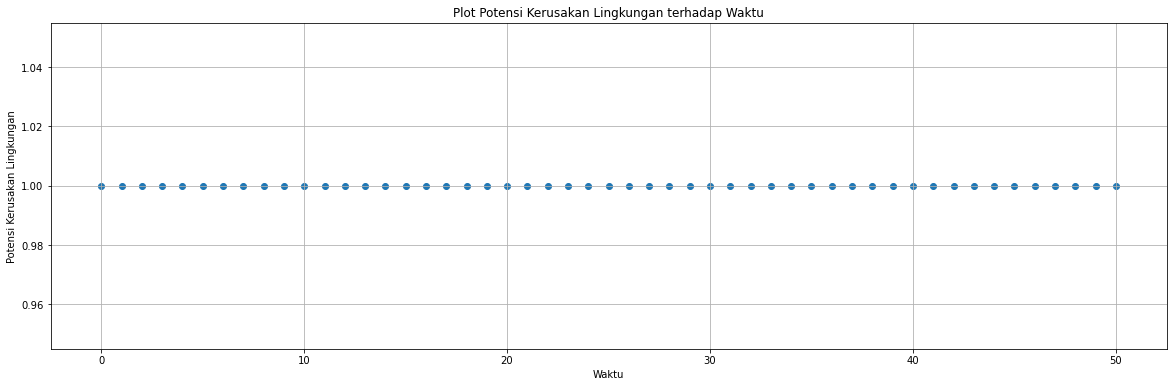

In [70]:
# Plotting Kondisi Lingkungan

sumbu_x = []
i = 0
while i <= time_step:
    sumbu_x.append(i)
    i += 1
    
sumbu_y = E

plt.figure(figsize=(20,6))
plt.scatter(sumbu_x, sumbu_y)
plt.title("Plot Potensi Kerusakan Lingkungan terhadap Waktu")
plt.xlabel("Waktu")
plt.ylabel("Potensi Kerusakan Lingkungan")

plt.grid(True)

plt.show()

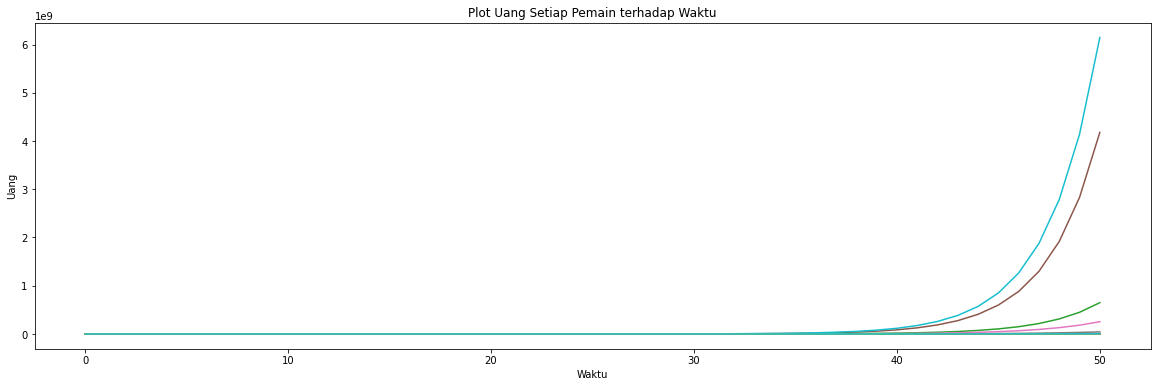

In [71]:
# Plotting Kondisi Setiap Pemain

plt.figure(figsize=(20,6))

i = 0
while i < N:
    plt.plot(sumbu_x, P_plot[i])
    i += 1

plt.title("Plot Uang Setiap Pemain terhadap Waktu")
plt.xlabel("Waktu")
plt.ylabel("Uang")

plt.show()

In [72]:
# hanya untuk cek cek

print(E)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


### Koding Looping 2

Koding berdasarkan prinsip permainan ekstensif

In [14]:
time_control = 1


while time_control <= time_step:
    
    # update nilai X. Ini aman karena di inisiasi kita sudah pakai X_new = X
    X = X_new
    
    # update nilai X di X_new
    i = 0
    while i < N:
        X_new[i] = x_optimum(i, P, X_new) # PEMBEDA DARI KODING 1
        i += 1
    
    # update matrix P berdasarkan X_new
    i = 0
    while i < N:
        
        # keuntungan total (uang total enaknya)
        P[i][0] = P[i][0] + X_new[i]*P[i][1]*P[i][0] + (1 - X_new[i])*P[i][2]*P[i][0]
        
        # randomisasi persentase keuntungan dari ekonomi hijau dan non hijau
        P[i][1] = P[i][1] + random.uniform(-koefisien_random_A, koefisien_random_A)*P[i][1]      # dalam persentase
        P[i][2] = P[i][2] + random.uniform(-koefisien_random_B, koefisien_random_B)*P[i][2]      # dalam persentase
        
        # update P_plot
        P_plot[i][time_control] = P[i][0]
        
        i += 1
        
    # Melihat kondisi lingkungan
    F.append(g(P, X_new))
    
    time_control += 1

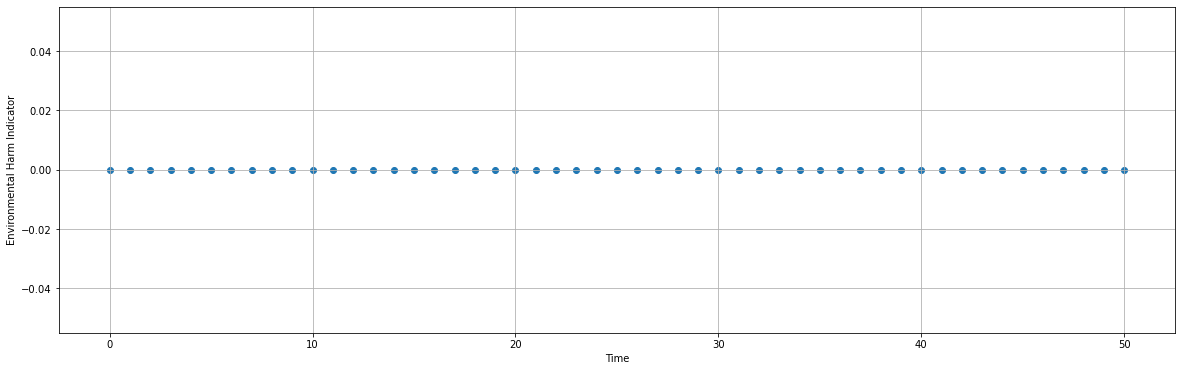

In [15]:
# Plotting Kondisi Lingkungan

sumbu_x = []
i = 0
while i <= time_step:
    sumbu_x.append(i)
    i += 1
    
sumbu_y = F

plt.figure(figsize=(20,6))
plt.scatter(sumbu_x, sumbu_y)
#plt.title("Plot Potensi Kerusakan Lingkungan terhadap Waktu")
plt.xlabel("Time")
plt.ylabel("Environmental Harm Indicator")

plt.grid(True)

plt.show()

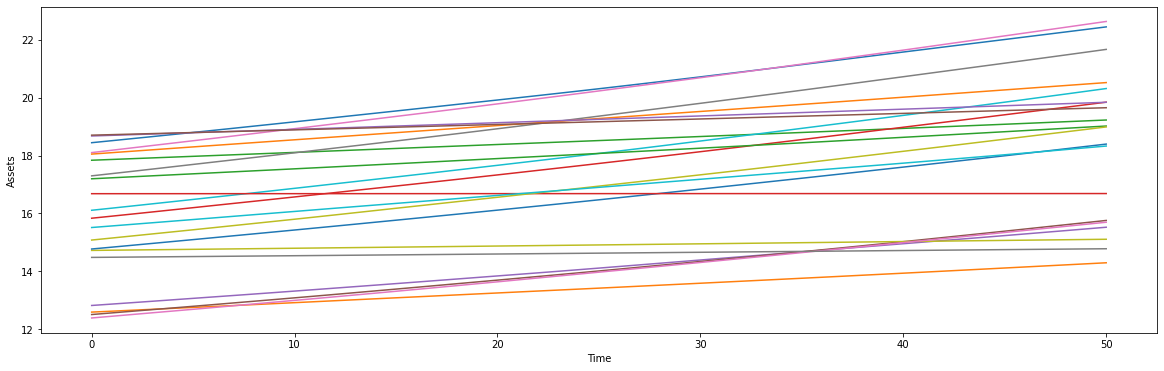

In [16]:
# Plotting Kondisi Setiap Pemain

plt.figure(figsize=(20,6))

i = 0
while i < N:
    plt.plot(sumbu_x, P_plot[i])
    i += 1

#plt.title("Plot Uang Setiap Pemain terhadap Waktu")
plt.xlabel("Time")
plt.ylabel("Assets")

plt.show()